<a href="https://colab.research.google.com/github/cloeav/PPD/blob/main/HR_Measurement_GreenChannelPPD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Heart Rate Measurement using the **Green Channel**


In [74]:
# ------Import standard libraries------
import math
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import the cv2_imshow function  from patches to use in Google Collab
from google.colab.patches import cv2_imshow 
# import functions from the scipy.signal module for signal processing
from scipy.signal import butter, filtfilt, find_peaks 
#import and mount the drive module to access files and directories from Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
 #------Function that detects where the face is located------ 
 # Returns the coordenates of the detected faces of the region of interest (ROI). 
 # Uses OpenCV's pre-trained Haar cascade classifier

def detect_roi(gray):
  # haarcascade_frontalface_default.xml' is the name of the pre-trained Haar cascade classifier file from OpenCV.
  face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/Colab Notebooks/PPD/haarcascade_frontalface_default.xml')
  faces = face_cascade.detectMultiScale(gray, scaleFactor=1.6, minNeighbors=5)        
  roi = frame[faces[0,1]:(faces[0,1]+faces[0,3]), faces[0,0]:(faces[0,0]+faces[0,2])]  
  # (x,y,width,length)
  return faces,roi 

In [76]:
#------Function that applies a butterworth bandpass filter to a signal------ 
# Returns the filtered signal 

def butter_bandpass_filter(signal, lowcut, highcut, fs):
    # Nyquist frequency = sampling rate (fps) / 2 
    nyq = fs/2
    low = lowcut / nyq
    high = highcut / nyq
    order = 3
    b, a = butter(order, [low, high], btype='band')
    filtered = filtfilt(b, a, signal)
    return filtered

In [77]:
#------Open the video file------
cap = cv2.VideoCapture('/content/drive/Shareddrives/Prácticas Profesionales/Videos/Juan60.mp4') # copy the path where the video file is located

In [78]:
#------Initialize variables for heart rate calculation------
fps = cap.get(cv2.CAP_PROP_FPS)
fps = round(fps) 
print("Frames per second:",fps)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print("Frame count:",frame_count) #Full video
signal_video = []

Frames per second: 60
Frame count: 7002


In [79]:
#------Calculate the initial and final frame------ 

# first 10 seconds of the video 
initial_frame = int(10*fps) 
# 60 seconds after the initial frame
final_frame = int(initial_frame + fps*60) 

#------Loop through each frame in the video (70 seconds) to extract the green channel ------
for i in range(1, final_frame): 

    # read the frame
    ret, frame = cap.read()

    # extract the green channel of 60 seconds of video without considering the first 10 seconds 
    if i>=initial_frame and i<final_frame:

      # convert the frame to grayscale
      gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

      # detect the ROI
      faces,roi = detect_roi(gray)
      #cv2_imshow(roi) #--﹥ uncomment to show the image of the ROI on the current frame
      #print(faces)    #--﹥ uncomment to print the detected faces on the current frame
      
      # extract the green channel from the ROI
      green_channel = roi[:,:,1]

      # normalize the green channel
      green_channel = cv2.normalize(green_channel, None, 0, 255, cv2.NORM_MINMAX)
      
      # add the green channel of the current frame to the signal 
      signal_video.append(np.mean(green_channel))

# release the video file and close all windows
cap.release()
cv2.destroyAllWindows()

# print the number of frames used to obtain the signal 
print(len(signal_video))

# convert to NumPy array 
signal_video = np.array(signal_video)
# print(filtered_signal) #--﹥ uncomment to print the signal

3600


In [80]:
#------Apply a bandpass filter to remove noise from the signal------
# lowcut freq  -->  60 bpm = 1 Hz 
# highcut freq -->  100 bpm = 1.67 Hz  

filtered_signal = butter_bandpass_filter(signal_video, 1, 1.67, fps)
# print(filtered_signal) #--﹥ uncomment to print the filtered signal)


In [81]:
#------Calculate the Fast Fourier Transform of the filtered signal ------
fft = np.fft.fft(filtered_signal)
#print(fft) --﹥ uncomment to print the fft 

# find the array of frequencies of each element in the FFT 
freqs = np.fft.fftfreq(filtered_signal.size, 1/fps)

# find the peaks of the FFT 
peaks, _ = find_peaks(np.abs(fft))

# print the number of peaks 
print(len(peaks))

# find the index of the highest peak
max_peak_index = np.argmax(np.abs(fft[peaks]))


160


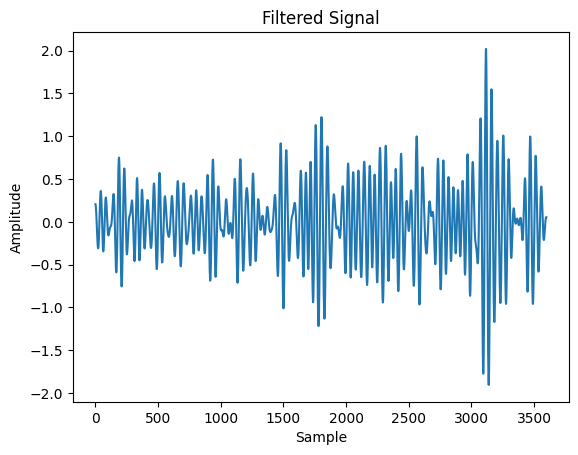

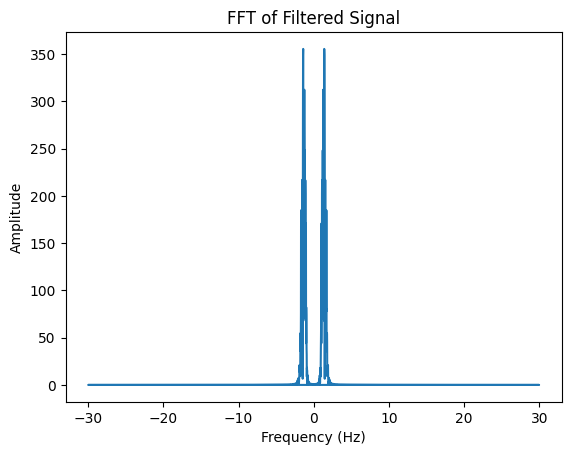

In [82]:
#------Plot the filtered signal------
plt.plot(filtered_signal)
plt.title('Filtered Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

#------Plot the FFT------
plt.figure()
plt.plot(freqs, np.abs(fft))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('FFT of Filtered Signal')
plt.show()

In [83]:
#------Calculate the Heart Rate using the peak frequency------

# Identify the peak frequency that corresponds to the heart rate an convert to bpm
heart_rate = freqs[peaks][max_peak_index] * 60 

# Print the heart rate
print("Heart rate: {:.2f} bpm".format(heart_rate))

Heart rate: 84.00 bpm


In [88]:
#------Compare to the heart rate calculated from pulse oximeter measurements------

# import the pulse oximeter .csv file 
data_video= pd.read_csv('/content/drive/Shareddrives/Prácticas Profesionales/Datos Pulsioximetro/juan_60_20230429154535.csv')

# extract the data from the PULSE column
pulse_signal = data_video['PULSE']

# eliminate the first 10 seconds and and take the next 60 values of the signal 
pulse_signal = pulse_signal[47:107] 

# print the size of the signal (must be 60 for 60 seconds)
print("Signal size:", pulse_signal.size)

# calculate and print the average value of the Heart Rate
heart_rate_csv = np.mean(pulse_signal)
print("\nHeart rate: {:.2f} bpm".format(heart_rate_csv))

# calculate and print the error 
error=abs(heart_rate-heart_rate_csv)
print("\nError: {:.2f} bpm".format(error))

Signal size: 60

Heart rate: 85.35 bpm

Error: 1.35 bpm
